# Cost of living preditions

In [3]:
import pandas as pd
from keplergl import KeplerGl

In [4]:
training_df = pd.read_csv("data/train.csv")
training_df.head()

,hex_id,cost_of_living
0,8866d338abfffff,0.372854
1,8866d331b1fffff,0.424494
2,888f2e3b4dfffff,0.414815
3,888f2b9ae5fffff,0.687205
4,8866d32363fffff,0.482482


In [5]:
map_1 = KeplerGl(data={"data": training_df})
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data':               hex_id  cost_of_living
0    8866d338abfffff        0.372854
1    8866d331…

As mentioned in the challenge description, training data is formed by a set of locations identified by their h3 representation and their corresponding cost of living. All the particular areas are in Ecuador and most of them are located in 5 highly dense areas and a few of them are sparse.

## Hypothesis 1: Closer areas have similar cost of living

This part of the notebook will try to demonstrate that the income of closer hexagon cells tends to be similar, for this task we will use exclusively the information on train.csv. If the hypothesis holds true, it will give us a good predictor for further machine learning models

The methodology implies computing the closeness of every pair of locations in the training dataset and checking whether the top k (1,2,3) closest cells are hold similar income levels.

In [25]:
import duckdb
import h3
import matplotlib.pyplot as plt
import numpy as np
import os
from helper import compute_neighbours_col
from helper import compute_neighbours_costs_for_row

In [7]:
map_closeup = KeplerGl(data={"data": training_df})
map_closeup

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data':               hex_id  cost_of_living
0    8866d338abfffff        0.372854
1    8866d331…

A close up to a more specific area such as Quito evidences that our hypothesis has a foundation, closer zones form clusters of cells with similar cost of living. Besides the visual insight, a numerical analysis has the potential to provide deeper knowledge about the phenomena.

To do so, we will leverage the h3_distance method available in the h3 library, which can easily help us to determine the distance (in number of cells) from a cell to another. 

In [9]:
training_df[["1_neigh", "2_neigh", "3_neigh", "4_neigh"]] = training_df.apply(
    lambda row: compute_neighbours_costs_for_row(row, training_df), 
    axis=1, 
    result_type="expand"
)

In [10]:
# visualize the result
training_df.head()

,hex_id,cost_of_living,1_neigh,2_neigh,3_neigh,4_neigh
0,8866d338abfffff,0.372854,0.462545,0.350434,0.335630,0.333378
1,8866d331b1fffff,0.424494,0.391206,0.418137,0.445683,0.426391
2,888f2e3b4dfffff,0.414815,NaN,NaN,0.650273,0.732745
3,888f2b9ae5fffff,0.687205,0.493089,0.583128,0.526477,0.534749
4,8866d32363fffff,0.482482,0.545707,0.504541,0.504977,0.492848


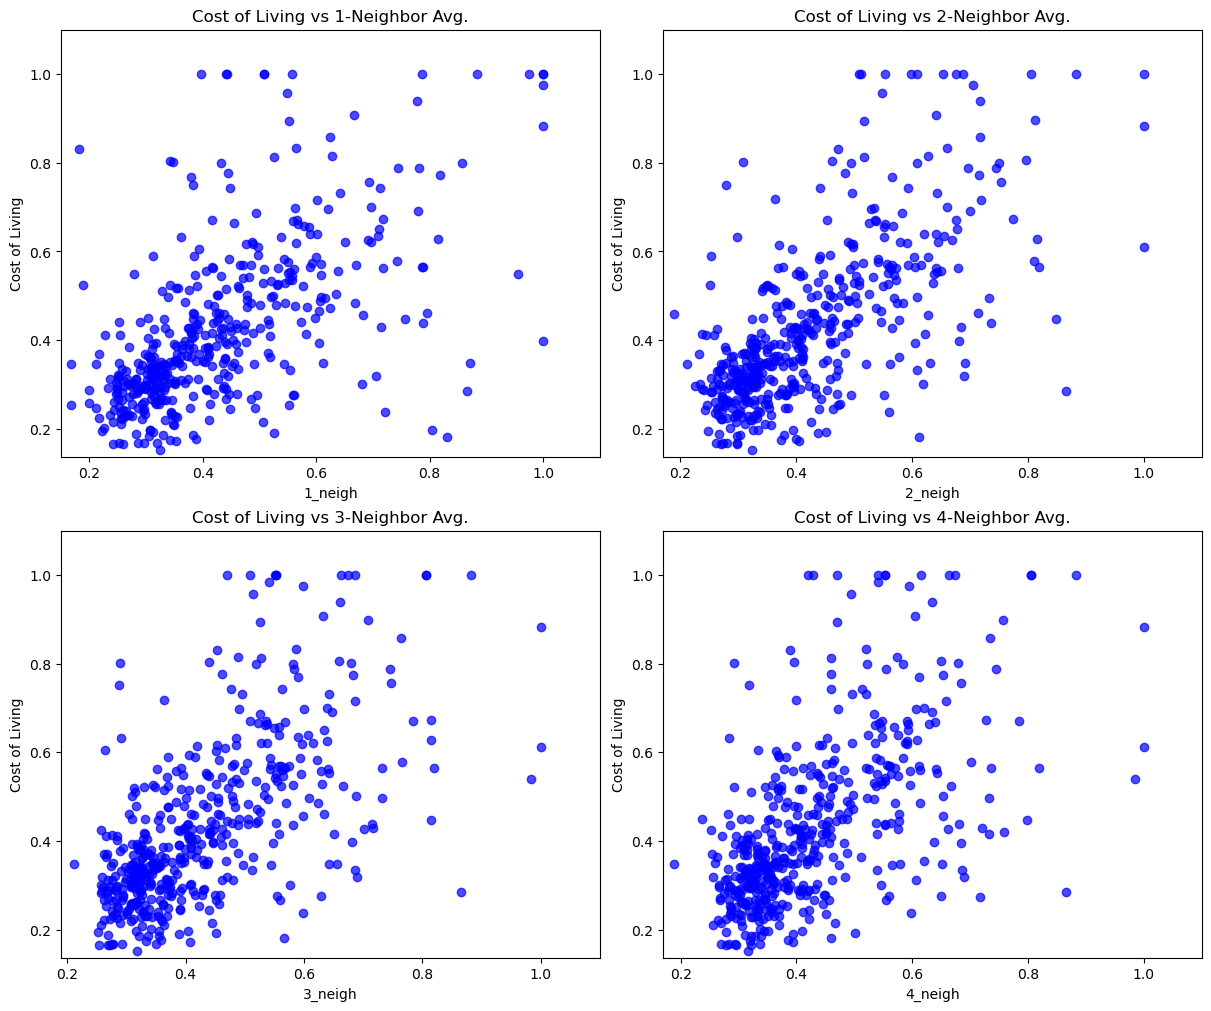

In [11]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# List of neighbor columns and titles
neighbors = ["1_neigh", "2_neigh", "3_neigh", "4_neigh"]
titles = [
    "Cost of Living vs 1-Neighbor Avg.",
    "Cost of Living vs 2-Neighbor Avg.",
    "Cost of Living vs 3-Neighbor Avg.",
    "Cost of Living vs 4-Neighbor Avg."
]

# Loop through each subplot and plot
for i, ax in enumerate(axes.flat):
    neighbor = neighbors[i]
    title = titles[i]
    
    # Scatter plot
    ax.scatter(training_df[neighbor], training_df["cost_of_living"], alpha=0.7, c='blue')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(f"{neighbor}", fontsize=10)
    ax.set_ylabel("Cost of Living", fontsize=10)
    
    # Handle NaN values
    ax.set_xlim(training_df[neighbor].min(skipna=True) * 0.9, training_df[neighbor].max(skipna=True) * 1.1)
    ax.set_ylim(training_df["cost_of_living"].min(skipna=True) * 0.9, training_df["cost_of_living"].max(skipna=True) * 1.1)

# Show the plot
plt.show()

In [12]:
# Compute Pearson correlation coefficients
for neighbor in neighbors:
    correlation = training_df[["cost_of_living", neighbor]].corr(method="pearson").iloc[0, 1]
    print(f"Pearson correlation between cost_of_living and {neighbor}: {correlation:.2f}")

Pearson correlation between cost_of_living and 1_neigh: 0.60
Pearson correlation between cost_of_living and 2_neigh: 0.67
Pearson correlation between cost_of_living and 3_neigh: 0.63
Pearson correlation between cost_of_living and 4_neigh: 0.58


In [13]:
# Use the column as predictor and evaluate over the training set:
for neighbor in neighbors:
    mae = (training_df[neighbor] - training_df["cost_of_living"]).abs().mean(skipna=True)
    print(f"Mean Absolute Error (MAE) between cost_of_living and {neighbor}: {mae:.2f}")

Mean Absolute Error (MAE) between cost_of_living and 1_neigh: 0.10
Mean Absolute Error (MAE) between cost_of_living and 2_neigh: 0.10
Mean Absolute Error (MAE) between cost_of_living and 3_neigh: 0.10
Mean Absolute Error (MAE) between cost_of_living and 4_neigh: 0.11


In [14]:
# Drawback: Not every location has a neighbour
for neighbor in neighbors:
    nan_count = training_df[neighbor].isna().sum()
    print(f"Number of NaN values in {neighbor}: {nan_count}")

Number of NaN values in 1_neigh: 63
Number of NaN values in 2_neigh: 35
Number of NaN values in 3_neigh: 25
Number of NaN values in 4_neigh: 15


By using our nearest neighbour adaptation we were able to derive an optimal feature that showed high correlation with our dependant variable and is able to predict the training set with a relatively small error. However, there is a major pitfall with this implementation related to the sparse areas which are unable to be predicted as they do not have near neighbours with the defined criteria.

The next step will be using our sole variable to predict the test set and determine the performance on unseen instances. I'll use a max distance of 2 as it showed the highest pearson correlation.

In [16]:
# Import test dataset
test_df = pd.read_csv("data/test.csv")
test_df.head()

,hex_id,cost_of_living
0,888f2b983dfffff,NaN
1,888f2864b7fffff,NaN
2,8866d33813fffff,NaN
3,888f0d9acdfffff,NaN
4,8866d33a03fffff,NaN


In [19]:
# Predict test set
for i in range(len(test_df)):
    row = test_df.iloc[i]
    test_df.loc[i, "cost_of_living"] = compute_neighbours_col(row, training_df, 2)

In [23]:
# Fill null values
avg_price_level = float(training_df["cost_of_living"].mean())
test_df.fillna(avg_price_level, inplace=True)

# Create the result folder if it does not exist
os.makedirs(os.path.dirname("results/"), exist_ok=True)

# Save the prediction
test_df.to_csv("results/hypothesis1.csv", index=False)

Our first approach showed a Mean Absolute Error (MAE) of 0.16154 for the test set, 60% higher compared to the performance on the training set, this is evidence of overfit. Let's include additional variables to increase the performance of our model.

## Hypothesis 2: Intense mobility areas tend to have a higher living cost

A high density of instances in the mobility dataset could indicate a higher cost of living, central areas with vibrant economic activity such as business or entertainment districts demand more mobility and at the same time tend to be relatively more expensive.

The goal of this part of the analysis is to prove the ground of the former claim. To do it, I'll check the correlation between the number of instances on the mobility data for each h3 cell and its corresponding cost of living. Additionally the same experiment will be repeated using the unique number of mobile devices detected on each cell.

Hopefully one of these two variables (or both of them) would be a relevant feature for our machine learning model.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [26]:
# Define the main table path and start duckdb connection
output = output_file = 'data/mobility_data_enriched.parquet'
conn = duckdb.connect()

In [27]:
# Use duckdb to format data
travel_instances_query = (
    f"SELECT h3_index, "
    f"       COUNT(*) AS n_instances, "
    f"       COUNT(DISTINCT device_id) AS n_devices "
    f"FROM '{output_file}' "
    f"GROUP BY h3_index "
    f"ORDER BY n_instances DESC"
)

travel_instances = conn.execute(travel_instances_query).fetchdf()
travel_instances.rename(columns={"h3_index": "hex_id"}, inplace=True)

travel_instances.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,hex_id,n_instances,n_devices
0,888f2b98edfffff,2730619,65685
1,8866d33ab1fffff,2699765,46146
2,8866d33a87fffff,2651239,47372
3,8866d33aabfffff,2353900,69074
4,888f2b9b1bfffff,2064149,69870


In [28]:
# Enrich the training data with the instances and devices data
training_df = training_df[["hex_id", "cost_of_living", "2_neigh"]]
training_df = training_df.merge(travel_instances, on="hex_id", how="left")
training_df.head()

,hex_id,cost_of_living,2_neigh,n_instances,n_devices
0,8866d338abfffff,0.372854,0.350434,597586.0,34852.0
1,8866d331b1fffff,0.424494,0.418137,NaN,NaN
2,888f2e3b4dfffff,0.414815,NaN,54057.0,799.0
3,888f2b9ae5fffff,0.687205,0.583128,565132.0,13258.0
4,8866d32363fffff,0.482482,0.504541,40220.0,496.0


In [29]:
# Handle null values
numeric_columns = ["cost_of_living", "2_neigh", "n_instances", "n_devices"]
training_df[numeric_columns] = training_df[numeric_columns].fillna(
    training_df[numeric_columns].mean()
)
training_df.head()

,hex_id,cost_of_living,2_neigh,n_instances,n_devices
0,8866d338abfffff,0.372854,0.350434,597586.000000,34852.000000
1,8866d331b1fffff,0.424494,0.418137,474360.290155,12501.746114
2,888f2e3b4dfffff,0.414815,0.427745,54057.000000,799.000000
3,888f2b9ae5fffff,0.687205,0.583128,565132.000000,13258.000000
4,8866d32363fffff,0.482482,0.504541,40220.000000,496.000000


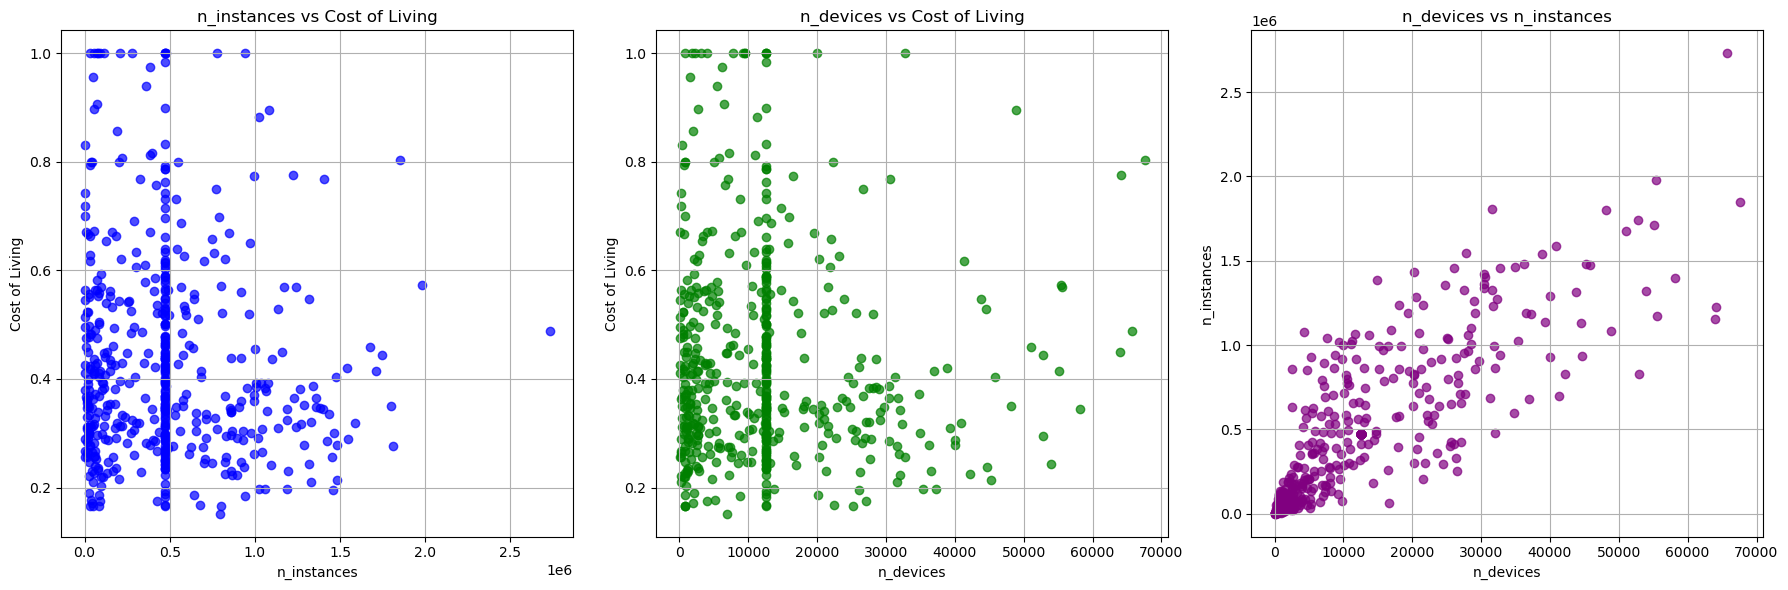

In [30]:
# explore correlation

# Set up the figure with three subplots
plt.figure(figsize=(18, 6))

# Scatterplot 1: n_instances vs cost_of_living
plt.subplot(1, 3, 1)
plt.scatter(training_df['n_instances'], training_df['cost_of_living'], alpha=0.7, color='blue')
plt.title('n_instances vs Cost of Living')
plt.xlabel('n_instances')
plt.ylabel('Cost of Living')
plt.grid(True)

# Scatterplot 2: n_devices vs cost_of_living
plt.subplot(1, 3, 2)
plt.scatter(training_df['n_devices'], training_df['cost_of_living'], alpha=0.7, color='green')
plt.title('n_devices vs Cost of Living')
plt.xlabel('n_devices')
plt.ylabel('Cost of Living')
plt.grid(True)

# Scatterplot 3: n_devices vs n_instances
plt.subplot(1, 3, 3)
plt.scatter(training_df['n_devices'], training_df['n_instances'], alpha=0.7, color='purple')
plt.title('n_devices vs n_instances')
plt.xlabel('n_devices')
plt.ylabel('n_instances')
plt.grid(True)

# Adjust spacing and display the plots
plt.tight_layout()
plt.show()

In [31]:
# Compute Pearson correlation coefficients
correlation_cost_inst = training_df[["n_instances", "cost_of_living"]].corr(method="pearson").iloc[0, 1]
correlation_cost_dev = training_df[["n_devices", "cost_of_living"]].corr(method="pearson").iloc[0, 1]
correlation_inst_dev =  training_df[["n_devices", "n_instances"]].corr(method="pearson").iloc[0, 1]
    
print(f"Pearson correlation between cost_of_living and n_instances: {correlation_cost_inst:.2f}")
print(f"Pearson correlation between cost_of_living and n_devices: {correlation_cost_dev:.2f}")
print(f"Pearson correlation between n_devices and n_instances: {correlation_inst_dev:.2f}")

Pearson correlation between cost_of_living and n_instances: -0.08
Pearson correlation between cost_of_living and n_devices: -0.04
Pearson correlation between n_devices and n_instances: 0.83


Surprisingly, there are not linear correlation between the density of instances (devices) and the cost of living, even so let's check whether it has any predictive power by running a couple of models.

As n_devices and n_instances are highly correlated, I'll skip the n_devices feature to avoid multicolinearity issues.

In [33]:
# Get a training and simulated test set

# Drop the 'hex_id' column as it's not a predictor
X = training_df.drop(columns=['hex_id', 'cost_of_living', 'n_devices'])
y = training_df['cost_of_living']

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (408, 2)
Test features shape: (102, 2)


In [35]:
# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name}:")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print('-' * 40)


Linear Regression:
  Mean Absolute Error: 0.0995
  R² Score: 0.4875
----------------------------------------
Random Forest:
  Mean Absolute Error: 0.1097
  R² Score: 0.4170
----------------------------------------
Gradient Boosting:
  Mean Absolute Error: 0.1062
  R² Score: 0.4423
----------------------------------------


By adding the n_instances variable, I got a MAE of 0.0995 on unseen data, which is smaller than the 0.16154 that resulted from my pseudo nearest-neighbor algorithm. This result is promising enough to try a new submission.

Let's predict the competition's test set to check the results of the lienar model.

In [36]:
# Add new columns to test set

num_columns = ["2_neigh", "n_instances"]
test_df.rename(columns={"cost_of_living": "2_neigh"}, inplace=True)
test_df = test_df.merge(travel_instances, on="hex_id", how="left")
test_df[num_columns] = test_df[num_columns].fillna(test_df[num_columns].mean())
test_df.head()

,hex_id,2_neigh,n_instances,n_devices
0,888f2b983dfffff,0.365397,1219969.0,42480.0
1,888f2864b7fffff,0.404916,11071.0,303.0
2,8866d33813fffff,0.398354,400352.0,17962.0
3,888f0d9acdfffff,0.567131,338313.0,10496.0
4,8866d33a03fffff,0.331075,966488.0,33838.0


In [37]:
prod_model = models["Linear Regression"]
Xr_test = test_df.drop(columns=['hex_id', 'n_devices'])
yr_test = prod_model.predict(Xr_test)
model_result = test_df.copy()
model_result["cost_of_living"] = 0
model_result["cost_of_living"] = yr_test
model_result.drop(columns=['2_neigh', 'n_instances', 'n_devices'], inplace=True)

In [38]:
model_result.to_csv("results/hypothesis2.csv", index=False)

This submission slightly improved the former score from 0.1615 to 0.1582, this result is considerably different from the one seen in the simulated test set

In [39]:
# Compute the number of rows in the test set that couldn't been assigned correctly the n_devices and n_instances columns
undetermined_rows = len(test_df[test_df["n_devices"].isna()])
print(undetermined_rows)

155


The difference could be originated by the high percentage of cells (30%) that couldn't be assigned the n_devices column. By filling this empty cells with the average of the column, we miss the opportunity to make a better imputation that boosts our results.

In order to perform a better imputation, for each null cell (in the n_devices column) I'll assign the average n_instances value for its 2 degree neighbors, this hopefully will be a better inputation than the average

In [40]:
# Impute null values in a smarter way

for i in range(len(test_df)):
    row = test_df.iloc[i]
    test_df.loc[i, "neigh_instances"] = compute_neighbours_col(row, training_df, 2, "n_instances")
    
test_df["n_instances"] = np.where(test_df["n_devices"].isna(), test_df["neigh_instances"], test_df["n_instances"])
test_df["n_instances"] = test_df["n_instances"].fillna(training_df["n_instances"].mean())

In [41]:
# Predict again:

prod_model = models["Linear Regression"]
Xr_test = test_df[["2_neigh", "n_instances"]]
yr_test = prod_model.predict(Xr_test)
model_result = test_df.copy()
model_result["cost_of_living"] = yr_test
model_result = model_result[["hex_id", "cost_of_living"]]

In [42]:
model_result.to_csv("hypothesis2_2.csv", index=False)

Very small improvement, MAE: 0.15804

## Hypothesis 3: Mobility concentration in certain hour ranges is correlated with the cost of living 

In [43]:
# Use duckdb to structure the data

travel_hours_query = (
    f"SELECT "
        f"CASE " 
        f"WHEN EXTRACT(HOUR FROM TO_TIMESTAMP(timestamp)) BETWEEN 7 AND 10 THEN '7to10' "
        f"WHEN EXTRACT(HOUR FROM TO_TIMESTAMP(timestamp)) BETWEEN 11 AND 14 THEN '11to14' "
        f"WHEN EXTRACT(HOUR FROM TO_TIMESTAMP(timestamp)) BETWEEN 15 AND 18 THEN '15to18' "
        f"WHEN EXTRACT(HOUR FROM TO_TIMESTAMP(timestamp)) BETWEEN 19 AND 22 THEN '19to22' "
        f"ELSE 'other' "
    f"END AS time_group, "
    f"  h3_index AS hex_id, "
    f"  COUNT(*) AS instances "
    f"FROM '{output_file}' "
    f"GROUP BY time_group, h3_index "
)
travel_hours = conn.execute(travel_hours_query).fetchdf()


travel_hours.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,time_group,hex_id,instances
0,other,8866d3285dfffff,34825
1,11to14,8866d33123fffff,227776
2,15to18,8866d32131fffff,20385
3,11to14,888f2b9843fffff,261069
4,7to10,888f2b9829fffff,235404


In [44]:
#Pivot table grouping by location

travel_hours = travel_hours.pivot_table(
    index="hex_id",
    columns="time_group",
    values="instances",
    aggfunc="sum",
    fill_value=0
).reset_index()

travel_hours.head()

time_group,hex_id,11to14,15to18,19to22,7to10,other
0,8866d14d05fffff,93174,88620,39497,75836,22289
1,8866d14d29fffff,46432,51683,19741,26480,6885
2,8866d14d2bfffff,15901,17809,14042,14946,12598
3,8866d14d63fffff,30582,35418,26179,30747,26331
4,8866d14d67fffff,11298,11178,7651,12763,11253


In [45]:
# Enrich training data with new info

training_df = training_df.merge(travel_hours, on="hex_id", how="left")
time_columns = ["11to14", "15to18", "19to22", "7to10"]
training_df[time_columns] = training_df[time_columns].fillna(training_df[time_columns].mean())
training_df["other"] = np.where(training_df["other"].isna(), 1 - training_df[time_columns].sum(axis=1), training_df["other"])
training_df.head()

,hex_id,cost_of_living,2_neigh,n_instances,n_devices,11to14,15to18,19to22,7to10,other
0,8866d338abfffff,0.372854,0.350434,597586.000000,34852.000000,118429.000000,131685.000000,123489.000000,115119.000000,108864.00000
1,8866d331b1fffff,0.424494,0.418137,474360.290155,12501.746114,98247.323834,105747.955959,89773.862694,87640.010363,-381408.15285
2,888f2e3b4dfffff,0.414815,0.427745,54057.000000,799.000000,8834.000000,8496.000000,10754.000000,9667.000000,16306.00000
3,888f2b9ae5fffff,0.687205,0.583128,565132.000000,13258.000000,151861.000000,177535.000000,103339.000000,79480.000000,52917.00000
4,8866d32363fffff,0.482482,0.504541,40220.000000,496.000000,8451.000000,8561.000000,7941.000000,7240.000000,8027.00000


In [46]:
# Get training and test set

X = training_df.drop(columns=['hex_id', 'cost_of_living', 'n_devices'])
y = training_df['cost_of_living']

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (408, 7)
Test features shape: (102, 7)


In [47]:
# Train the model with the new data:

# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name}:")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print('-' * 40)

Linear Regression:
  Mean Absolute Error: 0.1015
  R² Score: 0.4744
----------------------------------------
Random Forest:
  Mean Absolute Error: 0.1059
  R² Score: 0.4735
----------------------------------------
Gradient Boosting:
  Mean Absolute Error: 0.1053
  R² Score: 0.4634
----------------------------------------


This iteration had a higher MAE in the simulated test set compared with hypothesis 2, however, considering the result discrepancy between the simulated and real test set it is worth to give it a try

In [48]:
# Enrich test set with new data

test_df = test_df.merge(travel_hours, on="hex_id", how="left")
test_df[time_columns] = test_df[time_columns].fillna(training_df[time_columns].mean())
test_df["other"] = np.where(test_df["other"].isna(), 1 - test_df[time_columns].sum(axis=1), test_df["other"])

In [49]:
prod_model = models["Linear Regression"]
Xr_test = test_df[["2_neigh", "n_instances", "11to14", "15to18", "19to22", "7to10", "other"]]
yr_test = prod_model.predict(Xr_test)
model_result = test_df.copy()
model_result["cost_of_living"] = yr_test
model_result = model_result[["hex_id", "cost_of_living"]]

In [50]:
model_result.to_csv("results/hypothesis3.csv", index=False)

Hypothesis 3 scored a MAE of 0.159 which didn't improve our best score

## Hypothesis 4: Cells with high degree of returning visitors tend to have a higher cost

To test this hypothesis I'll compute the number of unique days that the average device visited the cell.

In [69]:
from helper import compute_h3_index

In [51]:
# Use duckdb to format the data

returning_df = conn.execute(
    f"SELECT h3_index AS hex_id, " 
        f"device_id, "
        f"COUNT( DISTINCT date_trunc('day', TO_TIMESTAMP(timestamp))) AS visits "
    f"FROM '{output_file}' "
    f"GROUP BY h3_index, device_id ").fetchdf()
returning_df.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,hex_id,device_id,visits
0,888f0d9a1bfffff,1962268,167
1,888f0d9a1bfffff,2042348,46
2,888f0d9a1bfffff,1727162,3
3,888f0d9a1bfffff,880219,12
4,888f0d9a1bfffff,157568,3


In [52]:
# Group by location

returning = returning_df.groupby("hex_id")["visits"].mean().reset_index()
returning.head()

,hex_id,visits
0,8866d14d05fffff,3.932488
1,8866d14d29fffff,3.928749
2,8866d14d2bfffff,3.593634
3,8866d14d63fffff,4.005462
4,8866d14d67fffff,3.086104


In [53]:
#Enrich training data with new columns

training_df = training_df.merge(returning, on="hex_id", how="left")
training_df["visits"] = training_df["visits"].fillna(training_df["visits"].mean())
training_df.head()

,hex_id,cost_of_living,2_neigh,n_instances,n_devices,11to14,15to18,19to22,7to10,other,visits
0,8866d338abfffff,0.372854,0.350434,597586.000000,34852.000000,118429.000000,131685.000000,123489.000000,115119.000000,108864.00000,3.120797
1,8866d331b1fffff,0.424494,0.418137,474360.290155,12501.746114,98247.323834,105747.955959,89773.862694,87640.010363,-381408.15285,4.059542
2,888f2e3b4dfffff,0.414815,0.427745,54057.000000,799.000000,8834.000000,8496.000000,10754.000000,9667.000000,16306.00000,3.947434
3,888f2b9ae5fffff,0.687205,0.583128,565132.000000,13258.000000,151861.000000,177535.000000,103339.000000,79480.000000,52917.00000,6.391613
4,8866d32363fffff,0.482482,0.504541,40220.000000,496.000000,8451.000000,8561.000000,7941.000000,7240.000000,8027.00000,4.727823


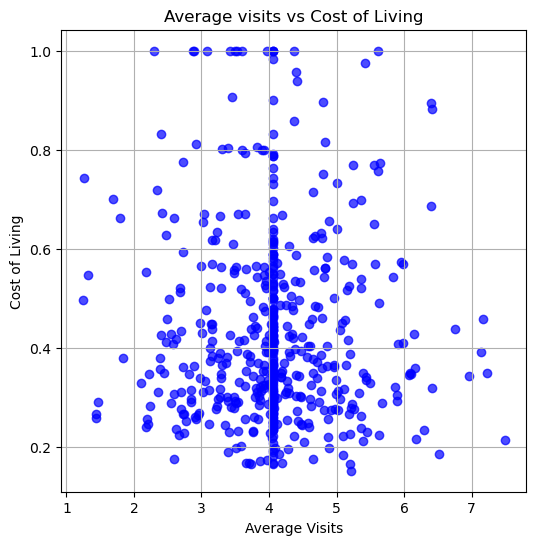

In [54]:
# Inspect for correlation

plt.figure(figsize=(6, 6))

# Scatterplot 1: n_instances vs cost_of_living
plt.subplot()
plt.scatter(training_df['visits'], training_df['cost_of_living'], alpha=0.7, color='blue')
plt.title('Average visits vs Cost of Living')
plt.xlabel('Average Visits')
plt.ylabel('Cost of Living')
plt.grid(True)

There are not apparent correlation between the two variables, let's check if it has any impact on the prediction

In [55]:
# Get training and test set

X = training_df.drop(columns=['hex_id', 'cost_of_living', 'n_devices'])
y = training_df['cost_of_living']

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Train the model

# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name}:")
    print(f"  Mean Absolute Error train: {mae_train:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print('-' * 40)

Linear Regression:
  Mean Absolute Error train: 0.1050
  Mean Absolute Error: 0.1017
  R² Score: 0.4711
----------------------------------------
Random Forest:
  Mean Absolute Error train: 0.0463
  Mean Absolute Error: 0.1049
  R² Score: 0.4735
----------------------------------------
Gradient Boosting:
  Mean Absolute Error train: 0.0669
  Mean Absolute Error: 0.1038
  R² Score: 0.4803
----------------------------------------


This feature did not improve our simulated test set score, let's see how it performs on the real test set

In [57]:
# Enrich test set with new info

test_df = test_df.merge(returning, on="hex_id", how="left")
test_df["visits"] = test_df["visits"].fillna(training_df["visits"].mean())
test_df.head()

,hex_id,2_neigh,n_instances,n_devices,neigh_instances,11to14,15to18,19to22,7to10,other,visits
0,888f2b983dfffff,0.365397,1219969.0,42480.0,1.230856e+06,365662.0,361327.0,179890.0,238360.0,74730.0,4.935993
1,888f2864b7fffff,0.404916,11071.0,303.0,4.743603e+05,2511.0,3063.0,1888.0,1832.0,1777.0,3.125413
2,8866d33813fffff,0.398354,400352.0,17962.0,1.101500e+06,71169.0,82605.0,84528.0,68788.0,93262.0,3.494989
3,888f0d9acdfffff,0.567131,338313.0,10496.0,6.618810e+05,66858.0,71266.0,67226.0,60991.0,71972.0,4.152344
4,8866d33a03fffff,0.331075,966488.0,33838.0,6.712729e+05,190540.0,208376.0,190110.0,194053.0,183409.0,4.878834


In [58]:
# Predict

prod_model = models["Linear Regression"]
Xr_test = test_df[["2_neigh", "n_instances", "11to14", "15to18", "19to22", "7to10", "other", "visits"]]
yr_test = prod_model.predict(Xr_test)
model_result = test_df.copy()
model_result["cost_of_living"] = yr_test
model_result = model_result[["hex_id", "cost_of_living"]]

In [59]:
model_result.to_csv("results/hypothesis4.csv", index=False)

## Hypothesis 5: Using additional info

Besides the mobility data, some additional information could lead to insight regarding to the cost of living, this could be the case for this [property dataset](https://www.kaggle.com/datasets/rmjacobsen/property-listings-for-5-south-american-countries?select=ec_properties.csv) offered by Property that captures information regarding houses, apartments and offices around different locations in Ecuador

In [60]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [62]:
properties = pd.read_csv("data/ec_properties.csv")
properties = properties.dropna(subset=['price'])
properties.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,puTf6SJMm87RSQKD7PfZHQ==,Propiedad,2019-11-16,9999-12-31,2019-11-16,-0.190255,-78.481672,Ecuador,Pichincha,Quito,...,NaN,100.0,15.0,280.0,USD,Mensual,Oficina / consultorio alquiler,Oficina de renta. Varios espacios compartidos ...,Oficina,Alquiler
1,Ikdxz61f/OO1ltcy74G9xQ==,Propiedad,2019-11-16,2020-02-08,2019-11-16,-0.184508,-78.480689,Ecuador,Pichincha,Quito,...,NaN,69.0,69.0,485.0,USD,Mensual,Departamentos alquiler,Suite de renta amoblada Av. República del Salv...,Departamento,Alquiler
2,WPWUMhGq7GG0KVC1O7YFJw==,Propiedad,2019-09-13,2019-10-22,2019-09-13,NaN,NaN,Ecuador,Loja,Loja,...,1.0,50.0,NaN,250.0,USD,NaN,Suite en Alquiler a 2 Cuadras del Coliseo de Loja,"Suite de 1 dormitorio, cuarto de baño, cocina,...",Departamento,Alquiler
3,IbFPsZtv9cnnrlBxZTYGhw==,Propiedad,2019-09-13,2019-10-26,2019-09-13,-4.001000,-79.202003,Ecuador,Loja,Loja,...,3.0,129.0,NaN,87900.0,USD,NaN,Casas en Venta de 4 Dormitorios Plan Vip,RESERVA TU CASA PROPIA CON TAN SOLO 1.000 DÓLA...,Casa,Venta
5,V5KrOWndVROLZyns3OsF2Q==,Propiedad,2019-09-13,2019-11-09,2019-09-13,NaN,NaN,Ecuador,Guayas,Guayaquil,...,2.0,120.0,NaN,550.0,USD,NaN,Cdla. Albatros Departamento en Alquiler,Departamento en Cdla. Albatros en Alquiler<br>...,Departamento,Alquiler


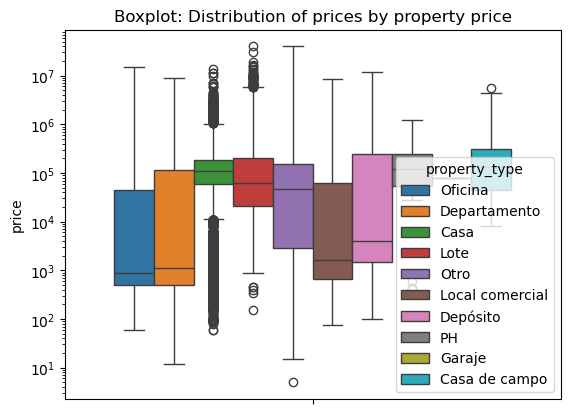

In [63]:
# Check the distribution by property type

sns.boxplot(data=properties, y="price", hue="property_type", log_scale=True)
plt.title("Boxplot: Distribution of prices by property price")
plt.show()

Text(0.5, 1.0, 'Boxplot: Distribution of price by operation type')

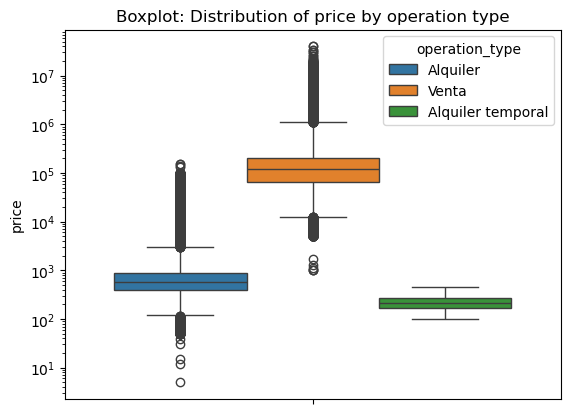

In [64]:
# Check the distribution by operation type

sns.boxplot(data=properties, y="price", hue="operation_type", log_scale=True)
plt.title("Boxplot: Distribution of price by operation type")

In [65]:
properties.groupby("operation_type")["id"].count()

operation_type
Alquiler             47112
Alquiler temporal        4
Venta                94841
Name: id, dtype: int64

Alquiler temporal has very small number of instances, lets drop it

In [66]:
# Drop alquiler temporal

properties = properties[properties["operation_type"] != "Alquiler temporal"]

Text(0.5, 1.0, 'Boxplot: Distribution of improved price by operation type')

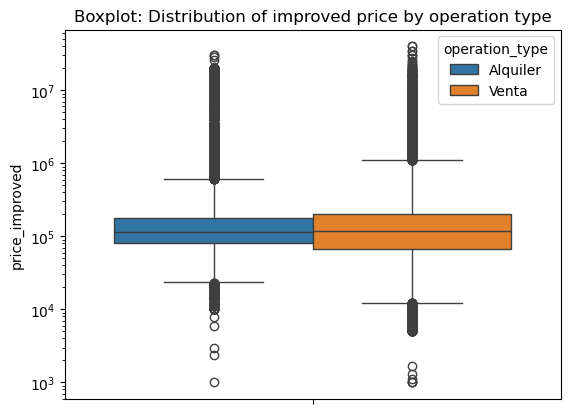

In [67]:
# Improve price to make the distribution of alquiler and venta similar

properties["price_improved"] = np.where(properties["operation_type"] == "Venta", properties["price"], properties["price"] * 200)
sns.boxplot(data=properties, y="price_improved", hue="operation_type", log_scale=True)
plt.title("Boxplot: Distribution of improved price by operation type")

In [70]:
# Add hex location index

properties["hex_id"] =  properties.apply(
                lambda row: compute_h3_index(row['lat'], row['lon']), axis=1
            )

# Display the instances
property_map = KeplerGl(data={"data": properties[["hex_id", "price_improved"]]})
property_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data':                  hex_id  price_improved
0       8866d33ab7fffff         56000.0
1      …

In [71]:
# Summarize by hex location

properties_tj = properties.groupby(["hex_id"])[["price_improved"]].mean().reset_index()
properties_tj.head()

,hex_id,price_improved
0,0,235245.75212
1,8866d00c67fffff,85000.00000
2,8866d021e7fffff,38000.00000
3,8866d02b53fffff,600000.00000
4,8866d039b9fffff,25000.00000


In [72]:
# Normalize the result

scaler = StandardScaler()
properties_tj['price_improved'] = scaler.fit_transform(properties_tj[['price_improved']])

In [73]:
# Enrich the training set
training_df = training_df.merge(properties_tj, on="hex_id", how="left")
training_df["price_improved"] = training_df["price_improved"].fillna(training_df["price_improved"].mean())
training_df.head()

,hex_id,cost_of_living,2_neigh,n_instances,n_devices,11to14,15to18,19to22,7to10,other,visits,price_improved
0,8866d338abfffff,0.372854,0.350434,597586.000000,34852.000000,118429.000000,131685.000000,123489.000000,115119.000000,108864.00000,3.120797,-0.103716
1,8866d331b1fffff,0.424494,0.418137,474360.290155,12501.746114,98247.323834,105747.955959,89773.862694,87640.010363,-381408.15285,4.059542,-0.172988
2,888f2e3b4dfffff,0.414815,0.427745,54057.000000,799.000000,8834.000000,8496.000000,10754.000000,9667.000000,16306.00000,3.947434,-0.257496
3,888f2b9ae5fffff,0.687205,0.583128,565132.000000,13258.000000,151861.000000,177535.000000,103339.000000,79480.000000,52917.00000,6.391613,-0.081858
4,8866d32363fffff,0.482482,0.504541,40220.000000,496.000000,8451.000000,8561.000000,7941.000000,7240.000000,8027.00000,4.727823,-0.107003


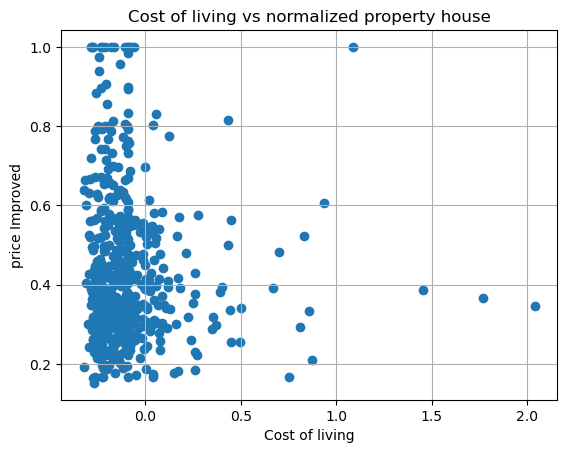

In [74]:
plt.scatter(training_df["price_improved"], training_df["cost_of_living"])
plt.title("Cost of living vs Price Improved")
plt.xlabel("Cost of living")
plt.ylabel("price Improved")
plt.title("Cost of living vs normalized property house")
plt.grid(True)

No aparent correlation

In [75]:
X = training_df.drop(columns=['hex_id', 'cost_of_living', 'n_devices'])
y = training_df['cost_of_living']

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name}:")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print('-' * 40)

Linear Regression:
  Mean Absolute Error: 0.1016
  R² Score: 0.4696
----------------------------------------
Random Forest:
  Mean Absolute Error: 0.1061
  R² Score: 0.4706
----------------------------------------
Gradient Boosting:
  Mean Absolute Error: 0.1069
  R² Score: 0.4476
----------------------------------------


In [77]:
# Enrich test set

test_df = test_df.merge(properties_tj, on="hex_id", how="left")
test_df["price_improved"] = test_df["price_improved"].fillna(training_df["price_improved"].mean())

In [78]:
prod_model = models["Linear Regression"]
Xr_test = test_df[["2_neigh", "n_instances", "11to14", "15to18", "19to22", "7to10", "other", "visits", "price_improved"]]
yr_test = prod_model.predict(Xr_test)
model_result = test_df.copy()
model_result["cost_of_living"] = yr_test
model_result = model_result[["hex_id", "cost_of_living"]]

In [79]:
model_result.to_csv("results/hypothesis5.csv", index=False)

## Test multiple models

In [80]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest (tuned):")
print(f"  Mean Absolute Error: {mae_rf:.4f}")

Random Forest (tuned):
  Mean Absolute Error: 0.1016


In [81]:
# Save results

yr_test = best_rf.predict(Xr_test)
model_result["cost_of_living"] = yr_test
model_result.to_csv("results/hypothesis5_5.csv", index=False)

In [82]:
# try more models
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize the models with pipelines (scaling is essential for SVR and MLPRegressor)
models = {
    "SVR": Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=10, epsilon=0.5))
    ]),
    "MLP Regressor": Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(random_state=42, hidden_layer_sizes=(32,), max_iter=1000, alpha=0.001))
    ])
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the training set
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    
    print(f"{model_name}:")
    print(f"  Training MAE: {train_mae:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print('-' * 40)


SVR:
  Training MAE: 0.2071
  Test MAE: 0.2183
  R² Score: -0.5275
----------------------------------------
MLP Regressor:
  Training MAE: 0.1157
  Test MAE: 0.1105
  R² Score: 0.3591
----------------------------------------
